# Imports & Data

In [123]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [8]:
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv

--2023-07-19 14:45:03--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.006s  

2023-07-19 14:45:03 (8.07 MB/s) - ‘insurance.csv’ saved [50264/50264]



In [12]:
!mkdir data
!mv insurance.csv data

In [17]:
df = pd.read_csv("data/insurance.csv")

# Data exploration

In [18]:
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


In [76]:
df.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [20]:
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [21]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [23]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object

In [25]:
df.corr().style.background_gradient(cmap = "coolwarm")

,age,bmi,children,expenses
age,1.000000,0.109341,0.042469,0.299008
bmi,0.109341,1.000000,0.012645,0.198576
children,0.042469,0.012645,1.000000,0.067998
expenses,0.299008,0.198576,0.067998,1.000000


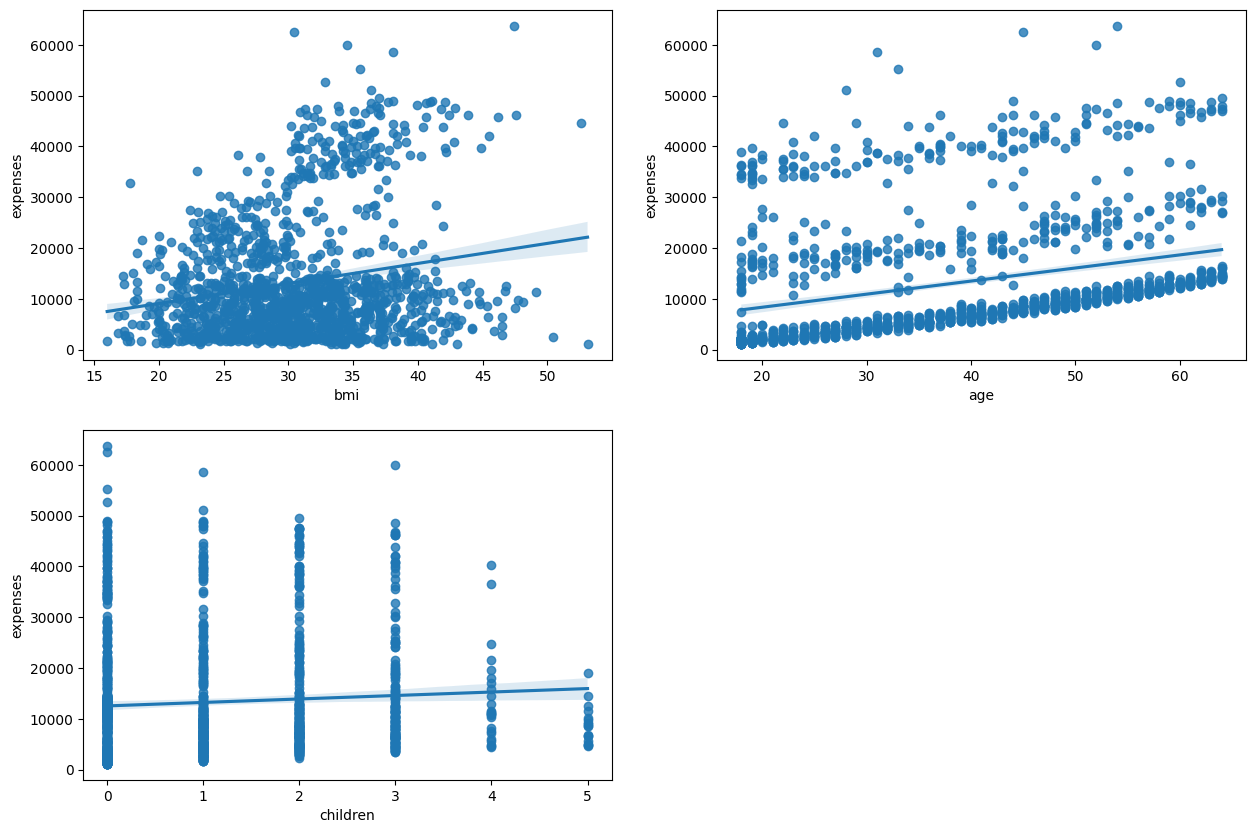

In [150]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.regplot(x = "bmi", y = "expenses", data = df, ci = 95)
plt.subplot(2,2,2)
sns.regplot(x = "age", y = "expenses", data = df, ci = 95)
plt.subplot(2,2,3)
sns.regplot(x = "children", y = "expenses", data = df, ci = 95);

# Regression task

## Check features statistics

In [158]:
features = ['age', 'bmi', 'children']
for feature in features: 
    print(f"{feature} explains {round((df.corr()[feature]['expenses']) ** 2 * 100, 2)}% of expenses' variations")

age explains 8.94% of expenses' variations
bmi explains 3.94% of expenses' variations
children explains 0.46% of expenses' variations


##### As we can see, the features don't seem to explain a strong percentage variation of expenses

In [165]:
model = smf.ols(formula='expenses ~ age + bmi + children', data=df)

In [166]:
model = model.fit()

In [167]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               expenses   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     60.74
Date:                Wed, 19 Jul 2023   Prob (F-statistic):           8.32e-37
Time:                        22:44:39   Log-Likelihood:                -14392.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1334   BIC:                         2.881e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6929.3145   1757.434     -3.943      0.000   -1.04e+04   -3481.678
age          239.9626     22.288     10.766      0.000     196.239     283.686
bmi          332.5216     51.307      6.481      0.000     231.870     433.173
children     543.0436    258.230      2.103      0.036      36.462    1049.625
==============================================================================
Omnibus:                      325.223   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              602.850
Skew:                           1.520   Prob(JB):                    1.24e-131
Kurtosis:                       4.254   Cond. No.                         290.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- As seen previously, we can observe that the R-squared value is low among the 
different features.
- However, the thresholds are significant since the p-value of each feature is 
less than 0.05. Therefore, we can see that, holding age and BMI constant, each 
additional child increases the expenses by $543.
- Thus, we can conclude that despite the statistical strength of the features, 
they only partially explain the relationship with the expenses.

## Split X & y

In [42]:
X = df.drop(columns="expenses")
y = df.expenses

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [52]:
X.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

## Preprocessing

In [53]:
num_features = ["age", "bmi"]
cat_features = ["sex", "children", "smoker", "region"]

In [55]:
num_pipeline = make_pipeline(RobustScaler())
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

In [57]:
preproc_pipeline = make_column_transformer((num_pipeline, num_features),
                                           (cat_pipeline, cat_features))

In [58]:
preproc_pipeline.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['age', 'bmi']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex', 'children', 'smoker', 'region'])])

In [59]:
X_train_preproc = preproc_pipeline.transform(X_train)
X_test_preproc = preproc_pipeline.transform(X_test)

## Model selection

In [119]:
models = [LinearRegression(), KNeighborsRegressor(), RandomForestRegressor(), DecisionTreeRegressor()]

In [120]:
for model in models:
    results = cross_validate(model, X_train_preproc, y_train, scoring=["neg_mean_absolute_error"], cv = 5, n_jobs=-1)
    results = np.mean(results["test_neg_mean_absolute_error"])
    print(f"{model} = {results}")

LinearRegression() = -4232.779498807347
KNeighborsRegressor() = -4108.923069158879
RandomForestRegressor() = -2801.4012648598136
DecisionTreeRegressor() = -3200.3841869158878


## Random Forest training

In [71]:
model_rf = RandomForestRegressor()

In [72]:
model_rf.fit(X_train_preproc, y_train)

RandomForestRegressor()

In [73]:
y_pred = model_rf.predict(X_test_preproc)

In [121]:
baseline_score = mean_absolute_error(y_test, y_pred)
baseline_score

2587.0425339552235

## Grid search

In [134]:
grid = {"n_estimators": [100, 200, 300, 400, 500],
        "min_samples_split": [2, 3, 4, 5],
        "min_samples_leaf": [1, 2, 3]}

In [135]:
grid_search = GridSearchCV(RandomForestRegressor(), param_grid=grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv = 5)

In [136]:
grid_search.fit(X_train_preproc, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_absolute_error')

In [137]:
grid_search.best_params_, grid_search.best_score_

({'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300},
 -2633.8296703783694)

## Update model

In [138]:
model_rf = grid_search.best_estimator_

In [139]:
y_pred_grid_search = model_rf.predict(X_test_preproc)

In [140]:
new_score = mean_absolute_error(y_test, y_pred_grid_search)
new_score

2396.526316650249

# Test on new data

In [141]:
data = ({"age": [57],
        "sex": ["female"], 
        "bmi": [22.7],
        "children": [2],
        "smoker": ["no"],
        "region": ["northeast"]})
X_new = pd.DataFrame(data = data)
X_new

,age,sex,bmi,children,smoker,region
0,57,female,22.7,2,no,northeast


In [142]:
X_new_preproc = preproc_pipeline.transform(X_new)

In [148]:
y_new = model_rf.predict(X_new_preproc)

In [149]:
f"This new client should pay: {round(y_new[0], 2)}$"

'This new client should pay: 13397.33$'